In [1]:
import pandas as pd
import numpy as np
from datetime import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")





TICKER                           : ETHUSDT
PERCENTAGE OF SUCCESSFUL TRADES  : 71.88 %
MAX DRAWDOWN OVER WINDOW         : 12.46
COMMISION LEVEL                  : 0.0


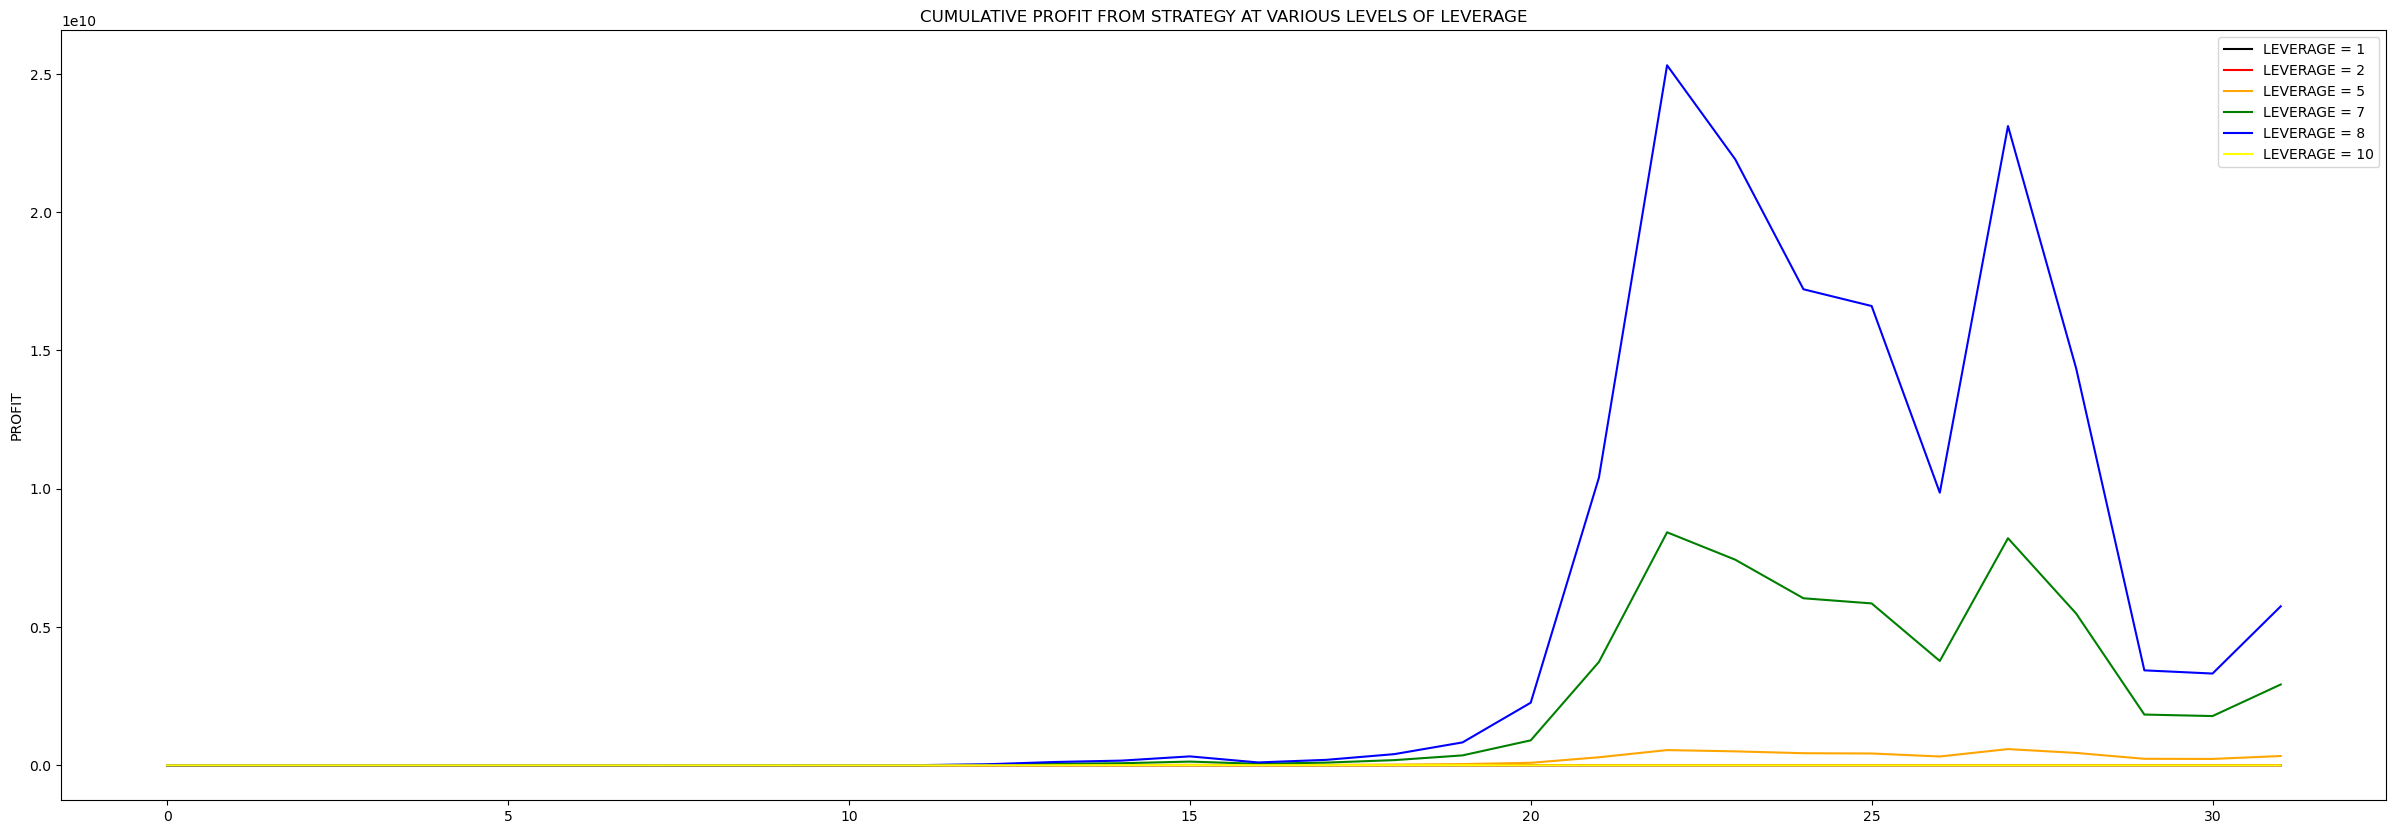

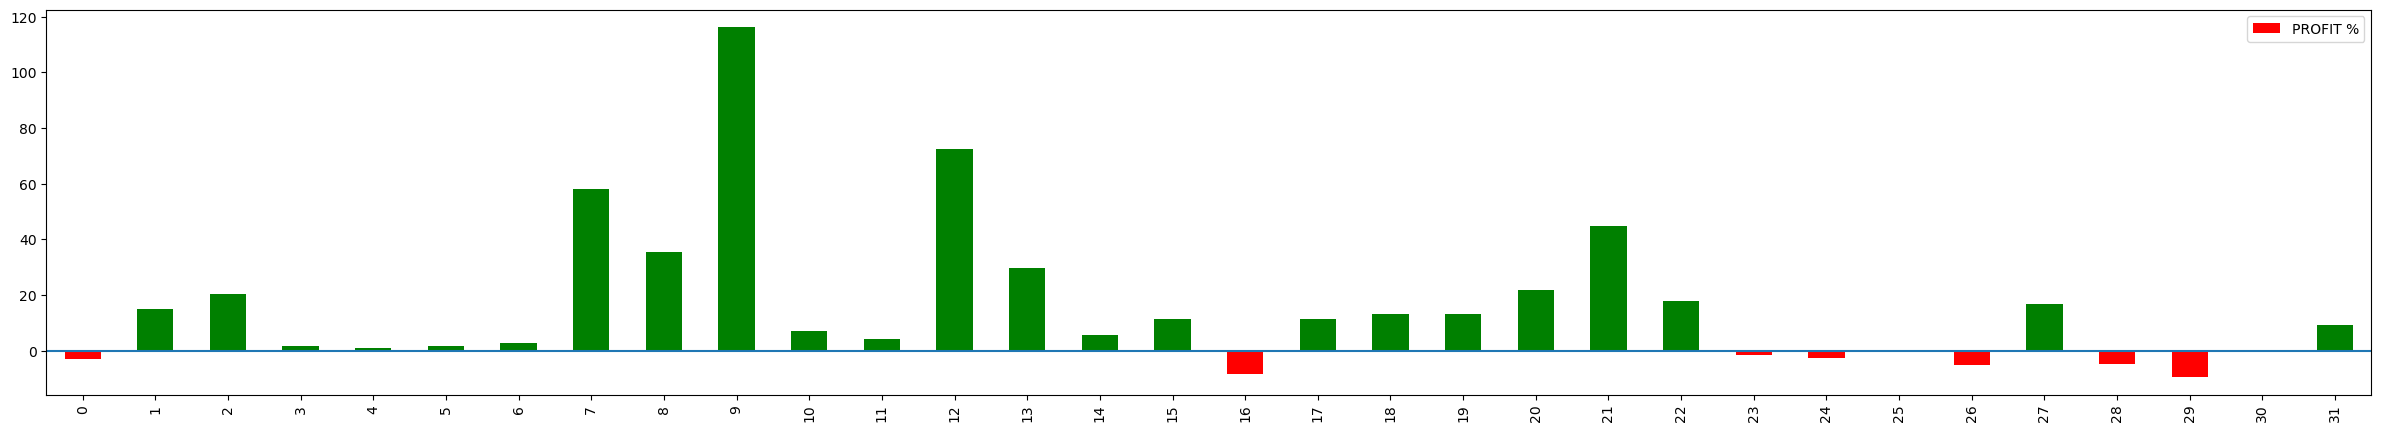

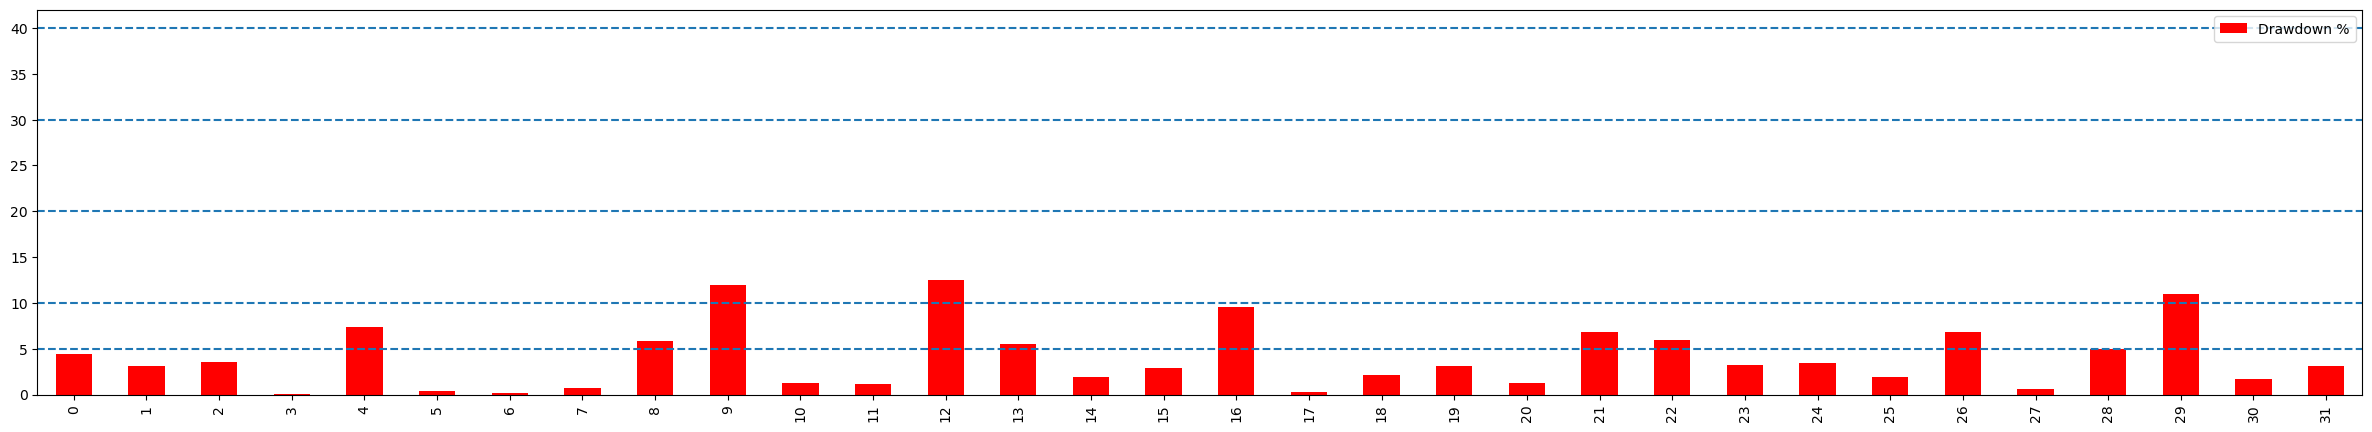

In [9]:
INVESTMENT_START                = 1500
COMMISSION                      = 0.000
LEVERAGE_LEVELS                 = [1, 2, 5, 7, 8, 10]



FILES                           = {"FILE_1" : "ELLIPSE ETHUSDT 4H.csv"}   
COIN                            = ['ETHUSDT']







for j in range(1, 2):
    CHOICE = j


    DF                              = SOURCE_DATA(CHOICE, FILES)
    DF, GROUP_DF, AGGREGATE_DF      = TRANSFORMATIONS(DF, INVESTMENT_START, COMMISSION, LEVERAGE_LEVELS)
    PERCENT_CORRECT                 = STATISTICS(GROUP_DF)

    PLOTTING(AGGREGATE_DF, LEVERAGE_LEVELS, DF)


    print('TICKER                           : ' + COIN[j-1])
    print('PERCENTAGE OF SUCCESSFUL TRADES  : ' + str(round(PERCENT_CORRECT,2)) + ' %')
    print('MAX DRAWDOWN OVER WINDOW         : ' + str(DF['Drawdown %'].max()))
    print('COMMISION LEVEL                  : ' + str(COMMISSION))

    








In [7]:

def SOURCE_DATA(CHOICE, FILES):
    ROOT                      = (r'/Users/westhomas/Downloads')
    df                        = pd.read_csv(ROOT + '/' + FILES['FILE_' + str(CHOICE)])
    
    if pd.isna(df.at[0, 'Price USDT']):
        df = df.iloc[2:]

    df = df.sort_values(by="Trade #", ascending=True)
    df = df.reset_index().iloc[:, 1:]
    
    if 'Unnamed: 0' in df.columns:
        del df['Unnamed: 0']
    
    del df['Contracts']
    del df['Profit USD']
    del df['Cum. Profit USD']
    del df['Run-up USD']
    del df['Run-up %']
    del df['Drawdown USD']
    
    return df


In [3]:

def TRANSFORMATIONS(df, INVESTMENT_START, COMMISSION, LEVERAGE_LEVELS):

    
    for q in range(len(LEVERAGE_LEVELS)):

        LEVERAGE               = LEVERAGE_LEVELS[q]
        FEES                   = (1 - (LEVERAGE * COMMISSION))
        
        INVESTMENT_AMOUNT_LIST = []
        INVESTMENT_TRADE_LIST  = []
        QUANTITY_LIST          = []
        PROFIT_USD_LIST        = []
        INVESTMENT_OUT_LIST    = []
        PROFIT_FINAL_LIST      = []
        COMMISSION_TRADE_LIST  = []


        for a in range(int(len(df)/2)):
            i = a * 2

            if i == 0:
                INVESTMENT_AMOUNT = INVESTMENT_START
                INVESTMENT_TRADE  = INVESTMENT_AMOUNT * FEES
                QUANTITY          = INVESTMENT_TRADE * df.at[i, 'Price USDT']
                PROFIT_USD        = (((((df.at[i, 'Profit %'] * LEVERAGE)/100) + 1) * QUANTITY) / df.at[i, 'Price USDT'])
                INVESTMENT_OUT    = PROFIT_USD * FEES
                PROFIT_FINAL      = INVESTMENT_OUT - INVESTMENT_AMOUNT 

            else:
                INVESTMENT_AMOUNT = INVESTMENT_OUT
                INVESTMENT_TRADE  = INVESTMENT_AMOUNT * FEES
                QUANTITY          = INVESTMENT_TRADE * df.at[i, 'Price USDT']
                PROFIT_USD        = (((((df.at[i, 'Profit %'] * LEVERAGE)/100) + 1) * QUANTITY) / df.at[i, 'Price USDT'])
                INVESTMENT_OUT    = PROFIT_USD * FEES
                PROFIT_FINAL      = INVESTMENT_OUT - INVESTMENT_AMOUNT 


            INVESTMENT_AMOUNT_LIST.append(INVESTMENT_AMOUNT)
            INVESTMENT_AMOUNT_LIST.append(INVESTMENT_AMOUNT)

            INVESTMENT_TRADE_LIST.append(INVESTMENT_TRADE)
            INVESTMENT_TRADE_LIST.append(INVESTMENT_TRADE)

            QUANTITY_LIST.append(QUANTITY)
            QUANTITY_LIST.append(QUANTITY)

            PROFIT_USD_LIST.append(PROFIT_USD)
            PROFIT_USD_LIST.append(PROFIT_USD)

            INVESTMENT_OUT_LIST.append(INVESTMENT_OUT)
            INVESTMENT_OUT_LIST.append(INVESTMENT_OUT)

            PROFIT_FINAL_LIST.append(PROFIT_FINAL)
            PROFIT_FINAL_LIST.append(PROFIT_FINAL)

        df['INVESTMENT_AMOUNT_' + str(LEVERAGE)] = INVESTMENT_AMOUNT_LIST
        df['INVESTMENT_TRADE_' + str(LEVERAGE)]  = INVESTMENT_TRADE_LIST
        df['QUANTITY_' + str(LEVERAGE)]          = QUANTITY_LIST
        df['PROFIT_USD_' + str(LEVERAGE)]        = PROFIT_USD_LIST
        df['INVESTMENT_OUT_' + str(LEVERAGE)]    = INVESTMENT_OUT_LIST
        df['PROFIT_FINAL_' + str(LEVERAGE)]      = PROFIT_FINAL_LIST
            
        for a in range(int(len(df)/2)):
            i = a * 2
            
            if (df.at[i, 'Drawdown %'] * LEVERAGE) >= 100:
                df.at[i, 'PROFIT_USD_' + str(LEVERAGE)]        = 0
                df.at[i, 'INVESTMENT_OUT_' + str(LEVERAGE)]    = 0
                df.at[i, 'PROFIT_FINAL_' + str(LEVERAGE)]      = 0

        for i in range(len(df)):
            if i != len(df)-1:
                if df.at[i, 'INVESTMENT_OUT_' + str(LEVERAGE)] == 0:
                    df.at[i+1, 'INVESTMENT_AMOUNT_' + str(LEVERAGE)] = 0
                    df.at[i+1, 'INVESTMENT_TRADE_' + str(LEVERAGE)]  = 0
                    df.at[i+1, 'QUANTITY_' + str(LEVERAGE)]          = 0
                    df.at[i+1, 'PROFIT_USD_' + str(LEVERAGE)]        = 0
                    df.at[i+1, 'INVESTMENT_OUT_' + str(LEVERAGE)]    = 0
                    df.at[i+1, 'PROFIT_FINAL_' + str(LEVERAGE)]      = 0


        GROUP_DF                   = df.groupby(['Trade #']).agg({'Profit %':'max', 'INVESTMENT_AMOUNT_' + str(LEVERAGE):'max', 'INVESTMENT_TRADE_' + str(LEVERAGE):'max', 'QUANTITY_' + str(LEVERAGE):'max', 'PROFIT_USD_' + str(LEVERAGE):'max', 'INVESTMENT_OUT_' + str(LEVERAGE):'max', 'PROFIT_FINAL_' + str(LEVERAGE):'max', 'Drawdown %':'max'}).rename(columns={'Profit %':'PROFIT %'})
        GROUP_DF                   = GROUP_DF.reset_index().rename(columns={'Trade no.':'TRADE NBR'})
        TEMP_DF                    = GROUP_DF[['Trade #', 'INVESTMENT_OUT_' + str(LEVERAGE)]].copy().rename({'Trade #': 'Trade'}, axis=1)


        
        if q == 0:
             AGGREGATE_DF = GROUP_DF[['Trade #','Drawdown %', 'PROFIT %', 'INVESTMENT_OUT_' + str(LEVERAGE)]].copy().rename({'Trade #': 'Trade'}, axis=1)
        else:
            AGGREGATE_DF = pd.merge(AGGREGATE_DF, TEMP_DF, how="outer", on=['Trade'])

    return df, GROUP_DF, AGGREGATE_DF



In [4]:


def PLOTTING(AGGREGATE_DF, LEVERAGE_LEVELS, DF):
    fig5, (ax6) = plt.subplots(1, sharex=True) 
    fig5.set_figheight(10) 
    fig5.set_figwidth(30) 

    ax6.set_ylabel('PROFIT') 
    ax6.set_title('CUMULATIVE PROFIT FROM STRATEGY AT VARIOUS LEVELS OF LEVERAGE')
    
    COLOURS = ['black', 'red', 'orange', 'green', 'blue', 'yellow']
    
    for q in range(len(LEVERAGE_LEVELS)):
        ax6.plot(AGGREGATE_DF['INVESTMENT_OUT_' + str(LEVERAGE_LEVELS[q])], label='LEVERAGE = ' + str(LEVERAGE_LEVELS[q]), color=COLOURS[q]) 
     
    plt.legend()

    fig6, (ax7) = plt.subplots(1, sharex=True)
    fig6.set_figheight(5) 
    fig6.set_figwidth(30) 
    
    colors = ['r' if m < 0 else 'g' for m in AGGREGATE_DF['PROFIT %']]
    AGGREGATE_DF.plot.bar(y='PROFIT %',color=colors, ax=ax7).axhline(y=0)
    
    fig7, (ax8) = plt.subplots(1, sharex=True)
    fig7.set_figheight(5) 
    fig7.set_figwidth(30) 
    
    colors = ['r' if m > 0 else 'g' for m in AGGREGATE_DF['Drawdown %']]
    AGGREGATE_DF.plot.bar(y='Drawdown %',color=colors, ax=ax8)
    [ax8.axhline(y=i, linestyle='--') for i in [5,10,20,30,40]]
    
    
    DF['Date/Time']       = pd.to_datetime(DF['Date/Time']) 
    DF['TIME']            = DF['Date/Time'].dt.time
    #DF.groupby(DF['TIME']).count().plot(kind="bar", label="")

    
    

In [5]:
def STATISTICS(GROUP_DF):
    
    FAIL_LIST = []
    
    for i in range(len(GROUP_DF)):
        if GROUP_DF.at[i, 'PROFIT %'] <= 0:
            FAIL_LIST.append(i)
    
    PERCENT_CORRECT = (1-(len(FAIL_LIST)/len(GROUP_DF)))*100
    
    return PERCENT_CORRECT
            